<h1 style="font-size:2.5rem;color:purple;">Artificial Intelligence II</h1>
<h1 style="font-size:1.5rem;color:purple;">Deep Learning for Natural Language Processing (NLP)</h1>

In this assignment, we develop a sentiment classifier by fine-tuning the pretrained model **BERT** in Python on a given Twitter dataset  
 (the same dataset used in Logistic Regression and DNN project).  

The dataset consists of three files: *train_dataset.csv, val_dataset.csv, test_dataset.csv*.  
Train and Val consists of three columns: **ID, Text, Label**, and Test consists of two columns: **ID, Text**.

In [104]:
# Import libraries

import pandas as pd

import warnings

import re

# For plots
import matplotlib.pyplot as plt
import seaborn as sns

# For wordclouds
from wordcloud import WordCloud
from collections import Counter

import numpy as np

# For metrics and metric visualization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [105]:
# Ingore warnings
warnings.filterwarnings("ignore")

In [106]:
np.random.seed(42)

Load the given data (*train.csv* to use for training, *val.csv* to use for validation of training and *test.csv* to use for predictions)

In [107]:
# Read train dataset (to use for training)
df_train = pd.read_csv('../datasets/train_dataset.csv')

# Read val dataset (to use for validation of training)
df_val = pd.read_csv('../datasets/val_dataset.csv')

# Read test dataset (to use for predictions)
df_test = pd.read_csv('../datasets/test_dataset.csv')

Let's take a look at the train dataset (the other two datasets have a similar structure to this one)

In [108]:
df_train

,ID,Text,Label
0,189385,@whoisralphie dude I'm so bummed ur leaving!,0
1,58036,"oh my god, a severed foot was foun in a wheely...",0
2,190139,I end up &quot;dog dialing&quot; sumtimes. Wha...,1
3,99313,@_rachelx meeeee toooooo!,0
4,157825,"I was hoping I could stay home and work today,...",0
...,...,...,...
148383,99894,just love the jonas brothers its tooo bad i w...,0
148384,61015,another day gone by....time is moving so fast...,0
148385,36598,"fuck college, i'm just gonna marry rich. : fuc...",1
148386,83799,ZOMGZ NEW SONG FTW. remember that night. &lt;3,1


Now we will make some plots to take a look at the dataset before "Data Preprocessing"

Visualize the most frequent words per label

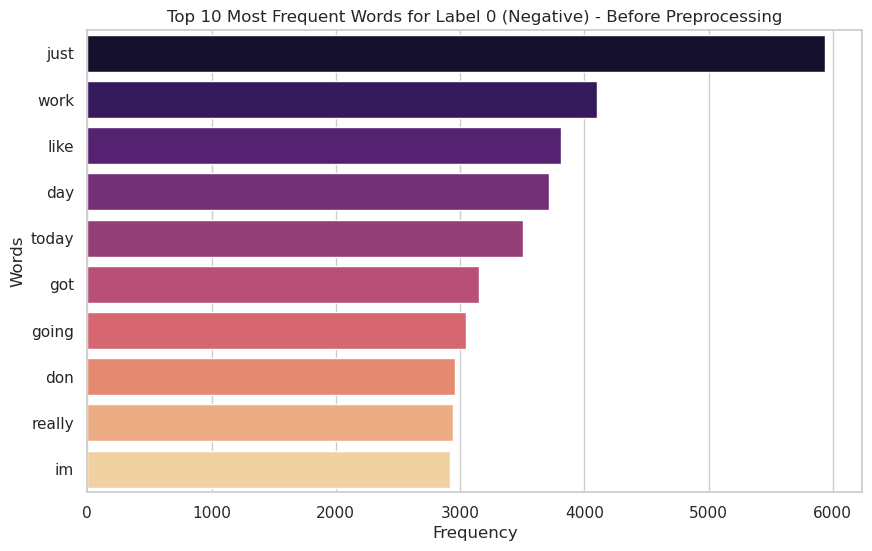

In [109]:
# Set CountVectorizer to count frequent words
vectorizer = CountVectorizer(stop_words='english')

sns.set(style='whitegrid')

label = 0
   
text_label = df_train[df_train['Label'] == label]['Text']
    
# Train CountVectorizer for this Label
X = vectorizer.fit_transform(text_label)
    
# Count frequent words
word_counts = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()
    
# Create a Counter to find top 10 frequent words
word_freq = Counter(dict(zip(words, word_counts)))
most_common_words = word_freq.most_common(10)

# Create plot for label
plt.figure(figsize=(10, 6))
plt.title(f'Top 10 Most Frequent Words for Label {label} (Negative) - Before Preprocessing')
    
words, counts = zip(*most_common_words)
    
# Create bar plot
sns.barplot(x=counts, y=words, palette='magma')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

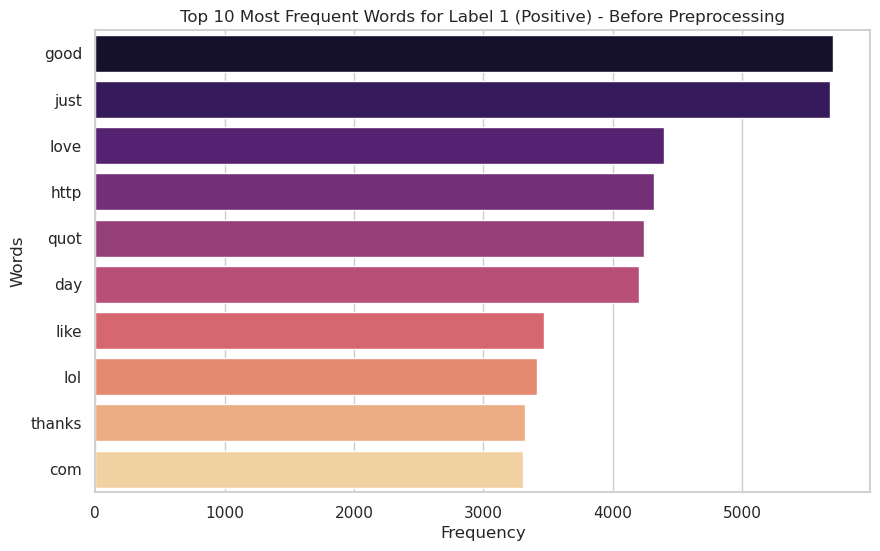

In [110]:
# Set CountVectorizer to count frequent words
vectorizer = CountVectorizer(stop_words='english')

sns.set(style='whitegrid')

label = 1
   
text_label = df_train[df_train['Label'] == label]['Text']
    
# Train CountVectorizer for this Label
X = vectorizer.fit_transform(text_label)
    
# Count frequent words
word_counts = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()
    
# Create a Counter to find top 10 frequent words
word_freq = Counter(dict(zip(words, word_counts)))
most_common_words = word_freq.most_common(10)

# Create plot for label
plt.figure(figsize=(10, 6))
plt.title(f'Top 10 Most Frequent Words for Label {label} (Positive) - Before Preprocessing')
    
words, counts = zip(*most_common_words)
    
# Create bar plot
sns.barplot(x=counts, y=words, palette='magma')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

Count and print the labels of Train and Validation set

In [111]:
# Count labels
label_counts = df_train["Label"].value_counts()

print("Labels in Train Set:")
print(f"Negative (0): {label_counts[0]}")
print(f"Positive (1): {label_counts[1]}")

Labels in Train Set:
Negative (0): 74192
Positive (1): 74196


In [112]:
# Count labels
label_counts = df_val["Label"].value_counts()

print("Labels in Validation Set:")
print(f"Negative (0): {label_counts[0]}")
print(f"Positive (1): {label_counts[1]}")

Labels in Validation Set:
Negative (0): 21197
Positive (1): 21199


The labels look balanced on both train and valitadion set.

<h1 style="font-size:1.5rem;color:purple;">Data Preprocessing</h1>
<h1 style="font-size:1.2rem;color:purple;">In this section we clean the datasets.</h1>

First we remove unwanted symbols/characters (e.g. URLs, @mentions, numbers/characters, hashtags).

In [113]:
# Function to clean text

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove mentions/usernames
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags but keep the words
    text = re.sub(r'#(\w+)', r'\1', text)
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Zά-ώΑ-Ω\s]', '', text)
    # Normalize spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

Clean text column in every dataframe

In [114]:
# Clean only Text column
df_train['Text'] = df_train['Text'].apply(clean_text)
df_val['Text'] = df_val['Text'].apply(clean_text)
df_test['Text'] = df_test['Text'].apply(clean_text)

Convert all text to lowercase

In [115]:
def text_lower(text):
    # Convert to lowercase
    text = text.lower()

    return text

In [116]:
df_train['Text'] = df_train['Text'].apply(text_lower)
df_val['Text'] = df_val['Text'].apply(text_lower)
df_test['Text'] = df_test['Text'].apply(text_lower)

Now take a look at the same dataset as above, but cleaned (the other two datasets are cleaned as well)

In [117]:
df_train

,ID,Text,Label
0,189385,dude im so bummed ur leaving,0
1,58036,oh my god a severed foot was foun in a wheely ...,0
2,190139,i end up quotdog dialingquot sumtimes whats do...,1
3,99313,meeeee toooooo,0
4,157825,i was hoping i could stay home and work today ...,0
...,...,...,...
148383,99894,just love the jonas brothers its tooo bad i wi...,0
148384,61015,another day gone bytime is moving so fast,0
148385,36598,fuck college im just gonna marry rich fuck col...,1
148386,83799,zomgz new song ftw remember that night lt,1


Drop rows with NaN values

In [118]:
# Drop NaN values
df_train = df_train.replace(r'^\s*$', pd.NA, regex=True).dropna()
df_val = df_val.replace(r'^\s*$', pd.NA, regex=True).dropna()

Replace NaN rows in **Test** set with the word "unknown" (we can't remove NaN values in this set, because of Kaggle competition submission.csv size)

In [119]:
df_test['Text'] = df_test['Text'].fillna("").apply(lambda x: "unknown" if not x.strip() else x)

Now let's check if we have rows that are "non-english"

Function to check if 80% of a text is english

In [120]:
def is_mostly_english(text, threshold=0.8):
    words = text.split()
    if not words:
        return False
    english_like = [w for w in words if re.match(r'^[a-zA-Z]+$', w)]
    return len(english_like) / len(words) >= threshold

Check if the 80% of text is english, in every row (for all three sets)

In [121]:
# -------------------------------- TRAIN SET --------------------------------
# Check and add an extra column for "True/False" if a text is english or not
df_train['is_english'] = df_train['Text'].apply(lambda x: is_mostly_english(x))

# Check for non-english rows
non_english_rows_train = df_train[~df_train['is_english']]


# ------------------------------ VALIDATION SET ------------------------------
# Check and add an extra column for "True/False" if a text is english or not
df_val['is_english'] = df_val['Text'].apply(lambda x: is_mostly_english(x))

# Check for non-english rows
non_english_rows_val = df_val[~df_val['is_english']]


# --------------------------------- TEST SET ---------------------------------
# Check and add an extra column for "True/False" if a text is english or not
df_test['is_english'] = df_test['Text'].apply(lambda x: is_mostly_english(x))

# Check for non-english rows
non_english_rows_test = df_test[~df_test['is_english']]


Print results

In [122]:
print("Non-english rows in Train set:", len(non_english_rows_train))

print("Non-english rows in Validation set:", len(non_english_rows_val))

print("Non-english rows in Test set:", len(non_english_rows_test))

Non-english rows in Train set: 0
Non-english rows in Validation set: 0
Non-english rows in Test set: 0


Drop extra column that marks English/Non-English text

In [123]:
df_train = df_train.drop(columns=['is_english'])
df_val = df_val.drop(columns=['is_english'])
df_test = df_test.drop(columns=['is_english'])

Reduce repeated characters in 2 (e.g. meeeeee toooooo -> mee too)

Function to reduce repeated characters

In [124]:
# Function to reduce repeated characters to 2
def reduce_repeated_characters(text):
   
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)  # Reduce characters repeated (3 or more times) to 2
    return text

Reduce repeated characters in Text columns

In [125]:
df_train['Text'] = df_train['Text'].apply(reduce_repeated_characters)
df_val['Text'] = df_val['Text'].apply(reduce_repeated_characters)
df_test['Text'] = df_test['Text'].apply(reduce_repeated_characters)

In [126]:
df_train

,ID,Text,Label
0,189385,dude im so bummed ur leaving,0
1,58036,oh my god a severed foot was foun in a wheely ...,0
2,190139,i end up quotdog dialingquot sumtimes whats do...,1
3,99313,mee too,0
4,157825,i was hoping i could stay home and work today ...,0
...,...,...,...
148383,99894,just love the jonas brothers its too bad i wil...,0
148384,61015,another day gone bytime is moving so fast,0
148385,36598,fuck college im just gonna marry rich fuck col...,1
148386,83799,zomgz new song ftw remember that night lt,1


Replace some frequent slang words with their original form

Create a dictionary with slang and original words

In [127]:
# Create a dictionary with slang word and their original form
abbreviations = {
    "im": "i am",
    "ur": "you are",
    "u": "you",
    "bummed": "sad",
    "mee": "me",
    "soo": "so",
    "ily": "i love you",
    "ok": "okay",
    "oke": "okay",
    "noo": "no",
    "luv": "love",
    "fb": "facebook",
    "cuz": "because",
    "ikr": "i know",
    "kno": "know",
    "knoo": "know",
    "sos": "help",
    "omg": "oh my god",
    "zomgz": "oh my god",
    "smh": "disappointment",
    "bday": "birthday",
    "wtf": "what the fuck",
    "not happy": "sad",
    "lt": "love it",
    "ftw": "awesome",
    "ftww": "awesome"
}

Function to replace slang words

In [128]:
# Function to replace slang
def replace_slang(text):
   
    for abbrev, full_form in abbreviations.items():
        text = re.sub(rf'\b{abbrev}\b', full_form, text, flags=re.IGNORECASE)
    
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

Replaced slang from all Text columns

In [129]:
df_train['Text'] = df_train['Text'].apply(replace_slang)
df_val['Text'] = df_val['Text'].apply(replace_slang)
df_test['Text'] = df_test['Text'].apply(replace_slang)

In [130]:
df_train

,ID,Text,Label
0,189385,dude i am so sad you are leaving,0
1,58036,oh my god a severed foot was foun in a wheely ...,0
2,190139,i end up quotdog dialingquot sumtimes whats do...,1
3,99313,me too,0
4,157825,i was hoping i could stay home and work today ...,0
...,...,...,...
148383,99894,just love the jonas brothers its too bad i wil...,0
148384,61015,another day gone bytime is moving so fast,0
148385,36598,fuck college i am just gonna marry rich fuck c...,1
148386,83799,oh my god new song awesome remember that night...,1


Remove words "got", "oh" , "im" and "just" since they're frequent and meaningless words for both labels

In [131]:
# Function to remove words "got", "oh", "im" and "just" from text
def remove_got(text):
    
    cleaned_text = re.sub(r'\b(got|oh|just|im)\b', '', text, flags=re.IGNORECASE)
    return re.sub(r'\s+', ' ', cleaned_text).strip()

In [132]:
df_train['Text'] = df_train['Text'].apply(remove_got)
df_val['Text'] = df_val['Text'].apply(remove_got)
df_test['Text'] = df_test['Text'].apply(remove_got)

Drop NaN values after data cleaning (also replace NaN values with "unknown" for test set)

In [133]:
# Drop NaN values
df_train = df_train.replace(r'^\s*$', pd.NA, regex=True).dropna()
df_val = df_val.replace(r'^\s*$', pd.NA, regex=True).dropna()

# Replace NaN
df_test['Text'] = df_test['Text'].fillna("").apply(lambda x: "unknown" if not x.strip() else x)

Below is the Train dataframe after data preprocessing

In [134]:
df_train

,ID,Text,Label
0,189385,dude i am so sad you are leaving,0
1,58036,my god a severed foot was foun in a wheely bin...,0
2,190139,i end up quotdog dialingquot sumtimes whats do...,1
3,99313,me too,0
4,157825,i was hoping i could stay home and work today ...,0
...,...,...,...
148383,99894,love the jonas brothers its too bad i wil neve...,0
148384,61015,another day gone bytime is moving so fast,0
148385,36598,fuck college i am gonna marry rich fuck colleg...,1
148386,83799,my god new song awesome remember that night lo...,1


<h1 style="font-size:1.5rem;color:purple;">Analysis</h1>
<h1 style="font-size:1.2rem;color:purple;">In this section we will try to visualize the data after preprocessing.</h1>

Create some wordclouds to make it clear and visible which words are used more often

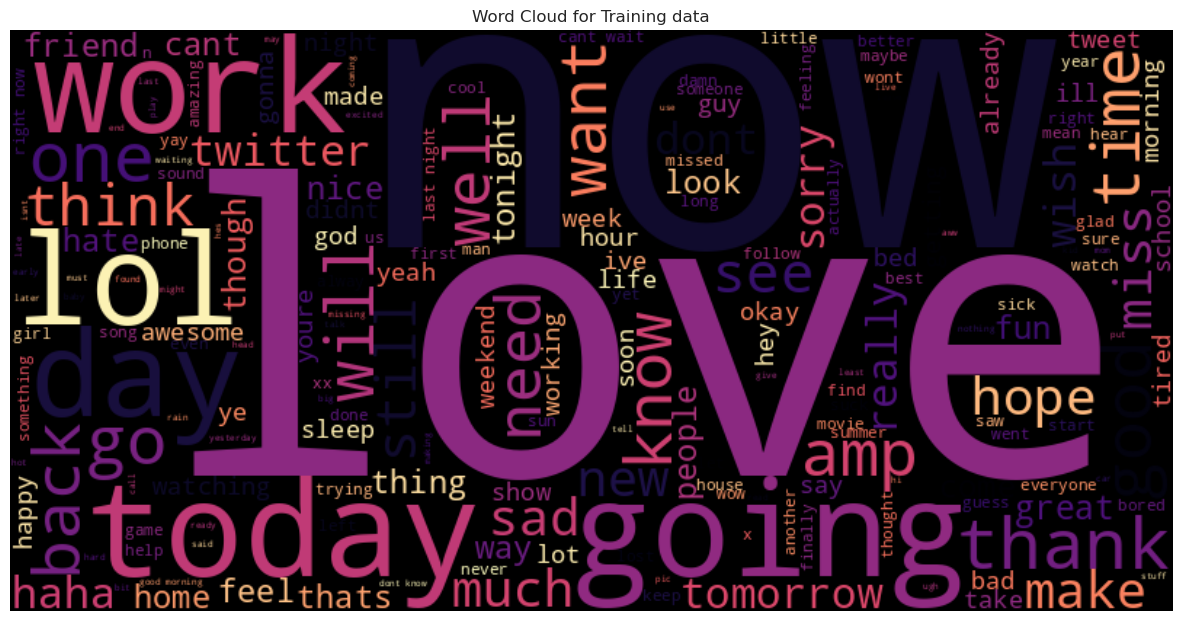

In [135]:
# Wordcloud for TRAINING DATA

# Combine all text entries into one string
text = " ".join(df_train['Text'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='magma').generate(text)

# Show the word cloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Training data")
plt.axis("off")
plt.show()

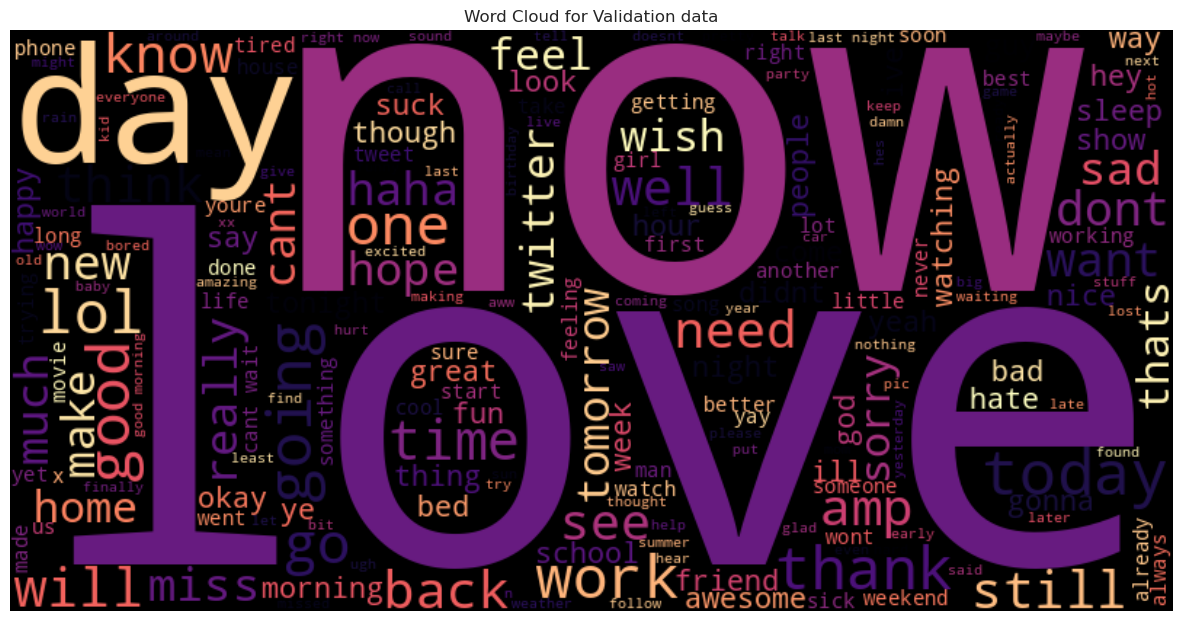

In [136]:
# Wordcloud for VALIDATION DATA

# Combine all text entries into one string
text = " ".join(df_val['Text'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='magma').generate(text)

# Show the word cloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Validation data")
plt.axis("off")
plt.show()

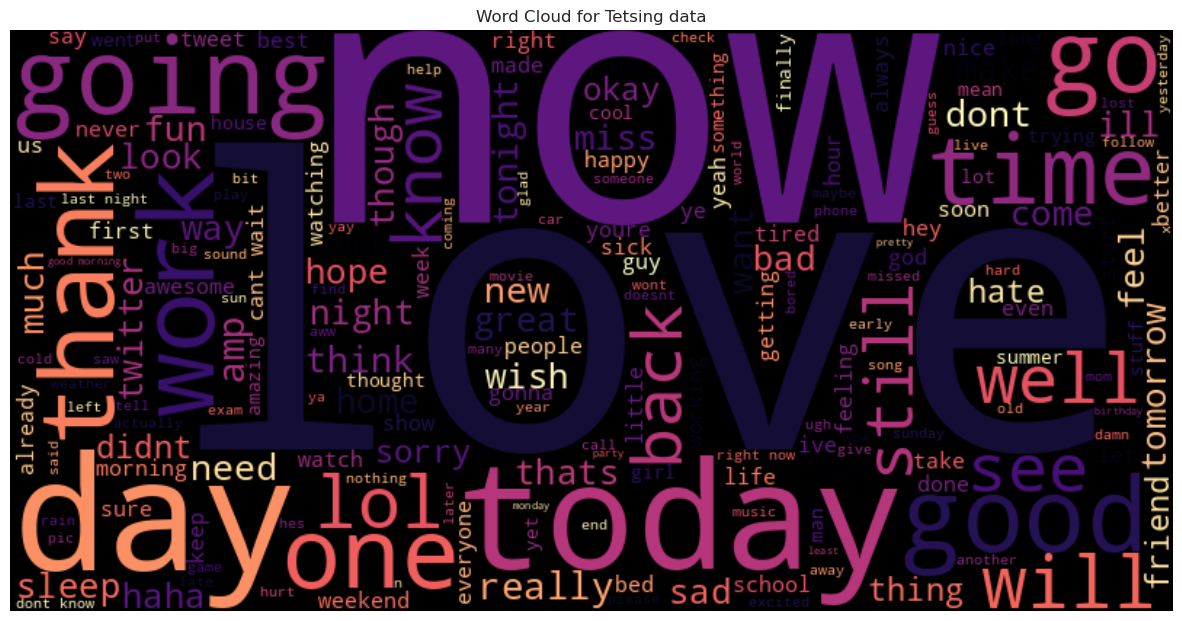

In [137]:
# Wordcloud for TESTING DATA

# Combine all text entries into one string
text = " ".join(df_test['Text'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='magma').generate(text)

# Show the word cloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Tetsing data")
plt.axis("off")
plt.show()

Count and make a pie chart for the label distribution (1 for positive, 0 for negative) in every dataframe  
(Test dataframe doesn't have "Label" column)

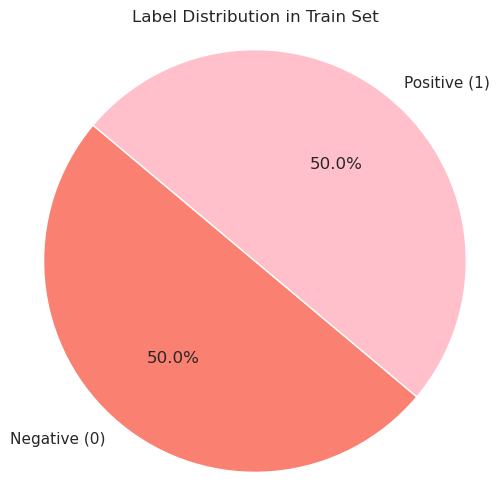

In [141]:
# Count labels
label_counts = df_train["Label"].value_counts()

# Define labels, counts and colors
labels = ['Negative (0)', 'Positive (1)']
sizes = [label_counts[0], label_counts[1]]
colors = ['salmon', 'pink']


# Create piechart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

plt.title('Label Distribution in Train Set')
plt.axis('equal')               # Equal aspect ratio for perfect circle
plt.show()

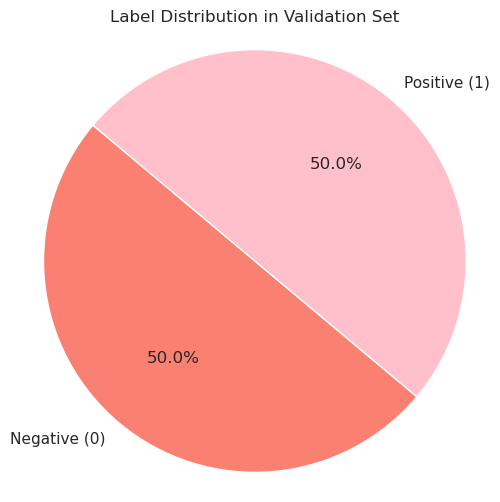

In [142]:
# Count labels
label_counts = df_val["Label"].value_counts()

# Define labels, counts and colors
labels = ['Negative (0)', 'Positive (1)']
sizes = [label_counts[0], label_counts[1]]
colors = ['salmon', 'pink']


# Create piechart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

plt.title('Label Distribution in Validation Set')
plt.axis('equal')               # Equal aspect ratio for perfect circle
plt.show()

The labels seem to be balanced, even after data preprocessing, since we have about equal numbers of positives and negatives in both dataframes.

Make some plots showing the top 10 most frequent words per label (for train set)

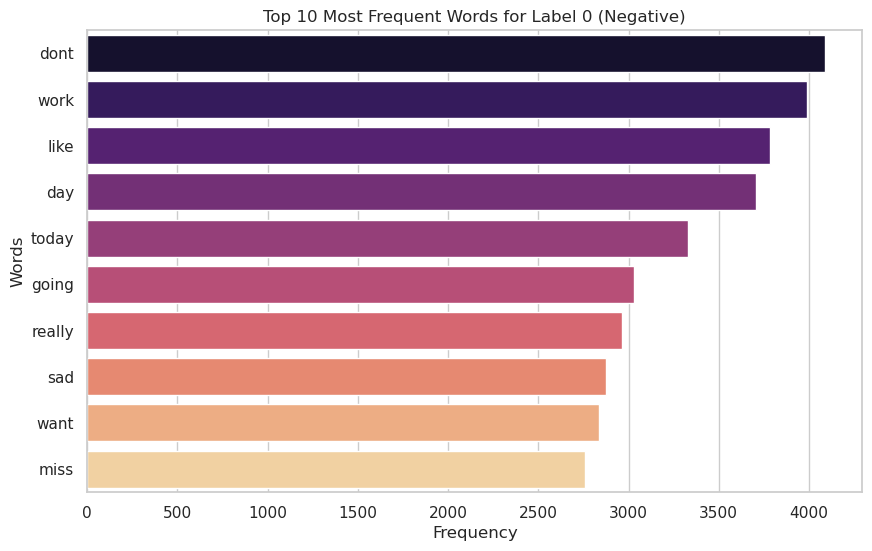

In [143]:
# Set CountVectorizer to count frequent words
vectorizer = CountVectorizer(stop_words='english')

sns.set(style='whitegrid')

label = 0
   
text_label = df_train[df_train['Label'] == label]['Text']
    
# Train CountVectorizer for this Label
X = vectorizer.fit_transform(text_label)
    
# Count frequent words
word_counts = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()
    
# Create a Counter to find top 10 frequent words
word_freq = Counter(dict(zip(words, word_counts)))
most_common_words = word_freq.most_common(10)

# Create plot for label
plt.figure(figsize=(10, 6))
plt.title(f'Top 10 Most Frequent Words for Label {label} (Negative)')
    
words, counts = zip(*most_common_words)
    
# Create bar plot
sns.barplot(x=counts, y=words, palette='magma')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

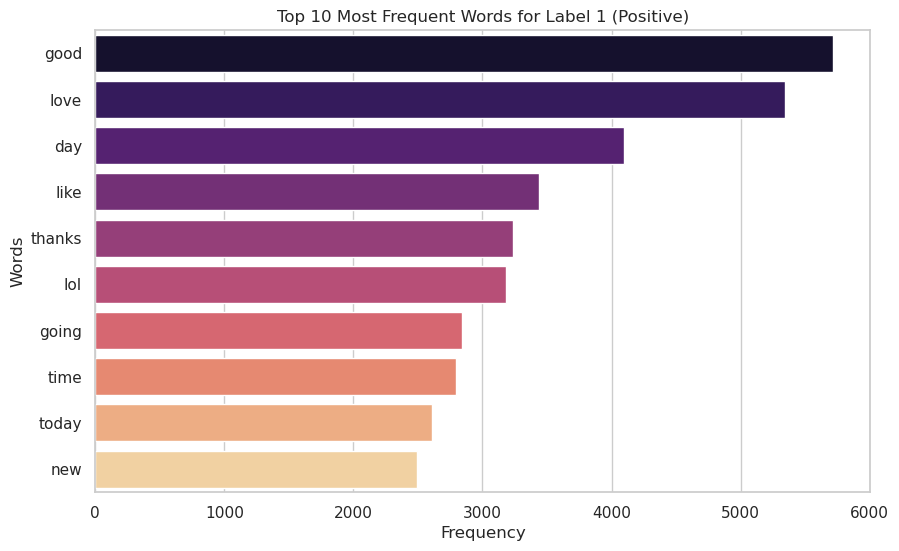

In [144]:
# Set CountVectorizer to count frequent words
vectorizer = CountVectorizer(stop_words='english')

sns.set(style='whitegrid')

label = 1
   
text_label = df_train[df_train['Label'] == label]['Text']
    
# Train CountVectorizer for this Label
X = vectorizer.fit_transform(text_label)
    
# Count frequent words
word_counts = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()
    
# Create a Counter to find top 10 frequent words
word_freq = Counter(dict(zip(words, word_counts)))
most_common_words = word_freq.most_common(10)

# Create plot for label
plt.figure(figsize=(10, 6))
plt.title(f'Top 10 Most Frequent Words for Label {label} (Positive)')
    
words, counts = zip(*most_common_words)
    
# Create bar plot
sns.barplot(x=counts, y=words, palette='magma')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

<h1 style="font-size:1.5rem;color:purple;">Vectorization</h1>
<h1 style="font-size:1.2rem;color:purple;">In this section we will convert text/data into numerical form so that it can be used by machine learning models.</h1>